# Enrollment Prediction - Gradient Boosting & Propensity Scoring

### Goals

* Identify the effect of scholarship amounts on a student's decision to enroll at the UW or not
* Use the original approach of HCRC; a binary logistic regression. 

### Process

* A. Load in data and software libraries
* B. Set the option flags for this run
* C. Create derived features (feature engineering part 1) 
* D. Dummify and generate combinatorial features (feature engineering part 2)
* E. Split into training and test sets and normalize
* F. Run a gradient boosting classification
* G. Evaluate the results for accuracy

### Resources

* http://blog.yhat.com/posts/logistic-regression-python-rodeo.html 
* http://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/
* http://www.dataschool.io/logistic-regression-in-python-using-scikit-learn/
* https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/

## Part A: Load in data and software libraries

### Part A1 - Load modules

In [1]:
# Load in software libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle

# Get data-munging libraries
from sklearn import preprocessing
from sklearn.preprocessing import Binarizer, FunctionTransformer, PolynomialFeatures
from sklearn import decomposition

# Get ML libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.decomposition import PCA

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split

from imblearn.over_sampling import SMOTE 

# Get Viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Part A2 - Load data

In [2]:
df = pd.read_csv('working_data_set_Lavi_clean.csv')
retention_df = pd.read_csv('retention_info.csv')

In [3]:
#These are tuition amounts for each year, non-resident. 
#http://opb.washington.edu/sites/default/files/opb/Tuition/2016-17%20Tuition%20%26%20Fee%20History.pdf

df.loc[df.yr == 2010, 'Tuition'] = 25329
df.loc[df.yr == 2011, 'Tuition'] = 28058
df.loc[df.yr == 2012, 'Tuition'] = 29938
df.loc[df.yr == 2013, 'Tuition'] = 31971
df.loc[df.yr == 2014, 'Tuition'] = 33513
df.loc[df.yr == 2015, 'Tuition'] = 34143
df.loc[df.yr == 2016, 'Tuition'] = 34791

### Part A3 - Initial data cleaning

In [4]:
#df = df.drop_duplicates(['system_key'])

In [5]:
# Drop unneeded columns
df.drop('system_key', axis=1, inplace=True)
df.drop('GenderDesc', axis=1, inplace=True)
df.drop('EthnicityDesc', axis=1, inplace=True)
df.drop('HighSchoolCode', axis=1, inplace=True)
df.drop('yr_to_use', axis=1, inplace=True)

df.drop('EnrollYrQtr', axis=1, inplace=True)
df.drop('FirstYrGPA', axis=1, inplace=True)
df.drop('FirstYrCredits', axis=1, inplace=True)
df.drop('TestDesc', axis=1, inplace=True)
df.drop('TotalBudgetRemaining', axis=1, inplace=True)
df.drop('TuitionRemaining', axis=1, inplace=True)
#df.drop('Fisap_Income', axis=1, inplace=True)

# Dubious origin state
df.drop('OriginState', axis=1, inplace=True)

In [6]:
df_backup = df.copy(deep=True)

In [7]:
# Look at the columns in the data
df.columns

Index([u'yr', u'yr_matched', u'HighestParentalEducation',
       u'PurpleAndGoldAmount', u'IsEnrolledOrMatriculated', u'EFC',
       u'Fisap_Income', u'Grants_and_Scholarships', u'UW_Grants', u'WorkLoans',
       u'Tuition', u'TotalBudget', u'HighSchoolGPA', u'TestScore',
       u'AcademicScore', u'AcademicRank', u'HolisticScore1', u'HolisticScore2',
       u'FinAidSegment', u'AcademicSegment', u'UWAttraction_TotalCount',
       u'UWAttraction_TotalPct', u'UWAttraction_ProdPct',
       u'UWLocationAttraction_TotalCount', u'UWLocationAttraction_TotalPct',
       u'UWEdGoals_TotalCount', u'UWEdGoals_TotalPct', u'UWEdGoals_ProdPct',
       u'LowerIncomePct', u'LowerIncomeCount', u'HigherIncomeCount',
       u'LowerParentEdPct', u'LowerParentEdCount', u'HigherParentEdCount',
       u'CollegeLocationPct_BorderState', u'FamilyIncomePct_140to200K',
       u'FirstGenerationPct_Not1stGen', u'ParentEducationPct_NoResponse',
       u'BioAndMed', u'CompSci', u'Eng', u'Business', u'PsychAnthro',
  

### Part A4 - Sanity checks

In [8]:
df.HolisticScore2.describe()

count    75741.000000
mean         2.367495
std          2.324528
min          0.000000
25%          0.000000
50%          4.000000
75%          4.666666
max          7.000000
Name: HolisticScore2, dtype: float64

In [9]:
df.PurpleAndGoldAmount.describe()

count    75741.000000
mean      1870.565480
std       3034.932912
min          0.000000
25%          0.000000
50%          0.000000
75%       4500.000000
max      14000.000000
Name: PurpleAndGoldAmount, dtype: float64

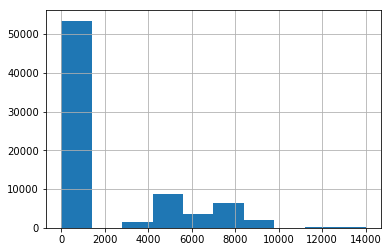

In [10]:
df.PurpleAndGoldAmount.hist()

In [11]:
df.PurpleAndGoldAmount.value_counts()

0        53458
5500      3995
7500      3908
6500      3481
5000      2532
4500      2119
8000      1387
8500      1048
7000      1019
9500      1014
4000       808
3000       679
14000      113
12000      111
9000        69
Name: PurpleAndGoldAmount, dtype: int64

## Part B - Set the option flags for this run

In [12]:
df['yr'].value_counts()

2016    18360
2015    17725
2014    14870
2013     7101
2012     6339
2011     6014
2010     5332
Name: yr, dtype: int64

### Part B1 - Set flags

Set the year
Visualize or not
Normalize or not
Simple or detailed accuracy metrics

In [13]:
use_all_years = False
year = 2016
use_most_recent = True

use_pugo_amounts = True

show_viz = False

normalize_metrics = True

stratify_split = True

save_results = True

model_choice = 'boosting' # options are 'boosting' and 'logit'

### Part B2 - Further data cleaning

In [14]:
if use_all_years == False:
    if use_most_recent == True:
        df = df[df['yr'].isin([2016, 2015, 2014])]
    else:
        df = df.loc[df['yr'] == year]

#df.drop('yr', axis=1, inplace=True)
df.drop('yr_matched', axis=1, inplace=True)

df = df.reset_index(drop=True)

df = df[np.isfinite(df['EFC'])]

df = df.dropna(how = 'any')

df.columns[df.isnull().sum() != 0]

Index([], dtype='object')

## Part C - Create Derived Features

### Part C1 - Create derived features (feature engineering)

* need_after_grants = total budgets minus grants
* need_after_grantsandincome = total budgets minus grants minus efc
* the amount a student would spend after all grants / scholarships

In [15]:
if use_pugo_amounts:
    df['tuition_after_grants'] = df['Tuition'] - df['PurpleAndGoldAmount'] - df['Grants_and_Scholarships']
else:
    df['tuition_after_grants'] = df['Tuition'] - df['Grants_and_Scholarships']

df.loc[df.tuition_after_grants < 0, 'tuition_after_grants'] = 0

In [16]:
df.tuition_after_grants.describe()

count    41448.000000
mean     31783.913844
std       3261.222676
min          0.000000
25%      28643.000000
50%      33513.000000
75%      34143.000000
max      34791.000000
Name: tuition_after_grants, dtype: float64

### Part C2 - Add retention info (feature engineering)

* 5-year graduation rate
* avg quarters to graduate
* avg+1 stdev quarters to graduate
* avg-1 stdev quarters to graduate

In [17]:
retention_df['5yr_grad_rate'] = retention_df['graduated_student_count'] * 1.0 / retention_df['student_count']

In [18]:
retention_df['avgplus1_quarters_to_graduate'] = retention_df['avg_quarters_to_graduate'] + retention_df['stdev_quarters_to_graduate']
retention_df['avgminus1_quarters_to_graduate'] = retention_df['avg_quarters_to_graduate'] - retention_df['stdev_quarters_to_graduate']
retention_df.ix[retention_df.avgminus1_quarters_to_graduate < 0, 'avgminus1_quarters_to_graduate'] = 0

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
retention_df.drop('graduated_student_count', axis=1, inplace=True)
retention_df.drop('student_count', axis=1, inplace=True)
retention_df.drop('stdev_quarters_to_graduate', axis=1, inplace=True)

In [20]:
df['first_major_category'] = 'Unknown'
df.loc[df.BioAndMed == 1, 'first_major_category'] = 'BioAndMed'
df.loc[df.CompSci == 1, 'first_major_category'] = 'CompSci'
df.loc[df.Business == 1, 'first_major_category'] = 'Business'
df.loc[df.Eng == 1, 'first_major_category'] = 'Eng'
df.loc[df.PsychAnthro == 1, 'first_major_category'] = 'PsychAnthro'
df.loc[df.ArtDesign == 1, 'first_major_category'] = 'ArtDesign'
df.loc[df.Law == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.loc[df.IntlStudies == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.loc[df.Nursing == 1, 'first_major_category'] = 'Nursing'
df.loc[df.Com == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.loc[df.Math == 1, 'first_major_category'] = 'MathAndScience'
df.loc[df.PhysicsAstr == 1, 'first_major_category'] = 'MathAndScience'
df.loc[df.Environ == 1, 'first_major_category'] = 'MathAndScience'
df.loc[df.English == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'

In [21]:
df['LowerHighSchoolGPA'] = 0
df.loc[df.HighSchoolGPA > 3.0, 'LowerHighSchoolGPA'] = 3
df.loc[df.HighSchoolGPA > 3.4, 'LowerHighSchoolGPA'] = 3.4
df.loc[df.HighSchoolGPA > 3.6, 'LowerHighSchoolGPA'] = 3.6
df.loc[df.HighSchoolGPA > 3.8, 'LowerHighSchoolGPA'] = 3.8

In [22]:
df['UpperHighSchoolGPA'] = 3
df.loc[df.HighSchoolGPA > 3, 'UpperHighSchoolGPA'] = 3.4
df.loc[df.HighSchoolGPA > 3.4, 'UpperHighSchoolGPA'] = 3.6
df.loc[df.HighSchoolGPA > 3.6, 'UpperHighSchoolGPA'] = 3.8
df.loc[df.HighSchoolGPA > 3.8, 'UpperHighSchoolGPA'] = 4.0

In [23]:
data_all = df.merge(retention_df, how='left', on=['first_major_category','LowerHighSchoolGPA','UpperHighSchoolGPA'])

In [24]:
data_all = data_all[data_all.TestScore > 0] #remove students with null entries here

In [25]:
data_all.drop('first_major_category', axis=1, inplace=True)
data_all.drop('TotalBudget', axis=1, inplace=True)
data_all.drop('UW_Grants', axis=1, inplace=True)
data_all.drop('AcademicRank', axis=1, inplace=True)

pugoTuitionAndGrantData = data_all[['PurpleAndGoldAmount', 'Grants_and_Scholarships', 'Tuition', 'yr']]
data_all.drop('yr', axis=1, inplace=True)
data_all.drop('Grants_and_Scholarships', axis=1, inplace=True)
data_all.drop('PurpleAndGoldAmount', axis=1, inplace=True)
data_all.drop('Tuition', axis=1, inplace=True)

print 'There are ' + str(data_all.HighSchoolGPA.count()) + ' rows'

There are 41125 rows


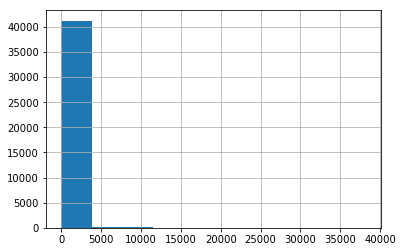

In [26]:
df.Grants_and_Scholarships.hist()

In [27]:
df.Grants_and_Scholarships.describe()

count    41448.000000
mean        54.878981
std        800.624543
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      38178.000000
Name: Grants_and_Scholarships, dtype: float64

## Part D - Dummify And Generate Combinatorial Features

### Part D1 - Create dummies

In [28]:
finaiddummy_df = pd.get_dummies(data_all['FinAidSegment'], prefix='finaid')
acaddummy_df = pd.get_dummies(data_all['AcademicSegment'], prefix='acad')
eddummy_df = pd.get_dummies(data_all['HighestParentalEducation'], prefix='ed')

eddummy_df['ed_1m'] = eddummy_df['ed_1']+eddummy_df['ed_2']+eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_2m'] = eddummy_df['ed_2']+eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_3m'] = eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_4m'] = eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_5m'] = eddummy_df['ed_5']+eddummy_df['ed_6']

# Join the binary variables to the data
data_all = data_all.join(eddummy_df)
data_all = data_all.join(finaiddummy_df)
data_all = data_all.join(acaddummy_df)

data_all.drop('FinAidSegment', axis=1, inplace=True)
data_all.drop('AcademicSegment', axis=1, inplace=True)
data_all.drop('HighestParentalEducation', axis=1, inplace=True)

data_all = data_all.reset_index(drop=True)

In [29]:
isEnrolledOrMatriculated = data_all.IsEnrolledOrMatriculated.copy()

In [30]:
#removal of null values

drop_all_nulls = True

if drop_all_nulls:
    cols = data_all.columns[data_all.isnull().any()]
    data_all = data_all.loc[~data_all[cols].isnull().any(axis = 1)]
    isEnrolledOrMatriculated = isEnrolledOrMatriculated.loc[data_all.index]

In [31]:
len(data_all)

41125

### Part D2 - Split off matrices for predictions

In [32]:
y = data_all.IsEnrolledOrMatriculated #target for predictions (just predicting yield here)
x = data_all.copy() #everything else

x.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)

### Part D3 - Create additional features

**Use PolynomialFeatures**

* Very useful - http://stackoverflow.com/questions/33257199/how-to-generate-many-interaction-terms-in-pandas
* Reference - http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html



* Complicated - http://www.dummies.com/programming/big-data/data-science/data-science-how-to-create-interactions-between-variables-with-python/
* http://patsy.readthedocs.io/en/latest/
* http://stats.idre.ucla.edu/stata/seminars/deciphering-interactions-in-logistic-regression/
* https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
* http://stackoverflow.com/questions/33050104/difference-between-the-interaction-and-term-for-formulas-in-statsmodels-ols

Note: part D3 was not found to be useful in predictions - Lavi

In [33]:
squaredFeatures = False
logFeatures = False
expFeatures = False
interactionFeatures = False

In [34]:
hold = x.copy()

if squaredFeatures:
    interactionFeatures = False
    poly = PolynomialFeatures(2, interaction_only = False, include_bias = False)
    temp = poly.fit_transform(hold)
    x = pd.DataFrame(temp, columns = poly.get_feature_names(x.columns), index = x.index)
if logFeatures:
    tempDF = hold.copy()
    tempDF[tempDF == 0] = 0.01
    temp = np.log(abs(tempDF))
    temp.columns = ['log-' + each for each in hold.columns]
    x = x.join(temp)
if expFeatures:
    tempDF = hold.copy()
    temp = np.exp(tempDF)
    temp[temp > 10000] = 10000
    temp.columns = ['exp-' + each for each in hold.columns]
    x = x.join(temp)
if interactionFeatures:
    scoreFeatures = False
    poly = PolynomialFeatures(2, interaction_only = True, include_bias = False)
    temp = poly.fit_transform(hold)
    x = pd.DataFrame(temp, columns = poly.get_feature_names(x.columns), index = x.index)    

In [35]:
#remove columns with all 0s or all 1s
x = x.drop(x.columns[(x == 0).all()], axis = 1)
x = x.drop(x.columns[(x == 1).all()], axis = 1)

In [36]:
x.shape

(41125, 77)

In [37]:
x.tail()

EFC  Fisap_Income  WorkLoans  HighSchoolGPA  TestScore  \
41120     0.0      -52824.0          0           3.39       1010   
41121  4164.0       75576.0          0           3.56       1415   
41122     0.0           0.0          0           3.66       1460   
41123     0.0           0.0          0           3.89       1565   
41124     0.0       33372.0          0           3.98       1265   

       AcademicScore  HolisticScore1  HolisticScore2  UWAttraction_TotalCount  \
41120       0.815063             0.0             0.0                     19.0   
41121       0.889156             0.0             0.0                    212.0   
41122       0.914625             2.0             5.0                    158.0   
41123       0.973344             0.0             0.0                    848.0   
41124       0.964344             0.0             0.0                    139.0   

       UWAttraction_TotalPct          ...            \
41120               1.961538          ...             
41121               1.780073          ...             
41122               1.191952          ...             
41123               1.562187          ...             
41124               1.514975          ...             

       finaid_FIN5 - $30K - $40K Needed  finaid_FIN6 - $40K+ Needed  \
41120                                 0                           1   
41121                                 0                           1   
41122                                 0                           0   
41123                                 0                           0   
41124                                 0                           1   

       acad_ACAD1 - 1106 SAT  acad_ACAD2 - 1258 SAT  acad_ACAD3 - 1283 SAT  \
41120                      1                      0                      0   
41121                      0                      0                      1   
41122                      0                      0                      0   
41123                      0                      0                      0   
41124                      0                      0                      0   

       acad_ACAD4 - 1297 SAT  acad_ACAD5 - 1314 SAT  acad_ACAD6 - 1327 SAT  \
41120                      0                      0                      0   
41121                      0                      0                      0   
41122                      1                      0                      0   
41123                      0                      0                      0   
41124                      0                      0                      0   

       acad_ACAD7 - 1350 SAT  acad_ACAD8 - 1451 SAT  
41120                      0                      0  
41121                      0                      0  
41122                      0                      0  
41123                      0                      1  
41124                      1                      0  

[5 rows x 77 columns]

## Part E - Split Into Training And Test Sets And Normalize

1. Come up with interaction terms
2. Use a 80-20 split

### Part E1 - Split in a 80-20 split

In [38]:
if stratify_split == True:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42, stratify=y)
else:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

print 'x_train has ' + str(len(x_train)) + ' observations'
print 'y_train has ' + str(len(y_train)) + ' observations'
print 'x_test has ' + str(len(x_test)) + ' observations'
print 'y_test has ' + str(len(y_test)) + ' observations'

#df_train = x_train.join(y_train)

x_train has 32900 observations
y_train has 32900 observations
x_test has 8225 observations
y_test has 8225 observations


In [39]:
#Note - this was moved here. Scaling should be done after train/test split and using train data as a basis! - Lavi

if normalize_metrics:
    #scaler = preprocessing.StandardScaler().fit(df_3)
    print 'Normalized'
    scaler = preprocessing.RobustScaler().fit(x_train) #Lavi - swapped to robust scaler
    x_train = pd.DataFrame(scaler.transform(x_train), index = x_train.index, columns = x_train.columns)
    x_test = pd.DataFrame(scaler.transform(x_test), index = x_test.index, columns = x_test.columns)

Normalized


### Part E2 - Use SMOTE

Note: Part E2 was not found to be useful in predictions - Lavi

In [40]:
smote = False 

if smote:
    sm = SMOTE(random_state = 11)
    colX = x_train.columns
    indX = x_train.index
    colY = y_train.name
    indY = y_train.index
    x_train, y_train = sm.fit_sample(x_train, y_train)
    x_train = pd.DataFrame(x_train, columns = colX)
    y_train = pd.Series(y_train, name = colY)

In [41]:
y_train.value_counts()

0    28518
1     4382
Name: IsEnrolledOrMatriculated, dtype: int64

In [42]:
#export data and use in cross validation scripts
x_train.join(y_train).to_csv('train.csv')

## Part F - Run Gradient Boosting Classifier

* http://statsmodels.sourceforge.net/devel/example_formulas.html
* http://statsmodels.sourceforge.net/stable/generated/statsmodels.discrete.discrete_model.Logit.html#statsmodels.discrete.discrete_model.Logit


In [43]:
clf = LogisticRegression(C = 1)
clf.fit(x_train, y_train)

probs = clf.predict_proba(x_train)
predicts = clf.predict(x_train)

probs_test = clf.predict_proba(x_test)
predicts_test = clf.predict(x_test)

In [44]:
check = pd.Series(clf.coef_[0], index = x.columns)
#print check['tuition_after_grants']
check.sort_values()

acad_ACAD1 - 1106 SAT              -1.044867
HolisticScore2                     -0.793533
ed_1m                              -0.791646
finaid_FIN6 - $40K+ Needed         -0.789898
ed_1                               -0.738477
finaid_FIN5 - $30K - $40K Needed   -0.641931
acad_ACAD8 - 1451 SAT              -0.622186
avg_quarters_to_graduate           -0.576968
ed_2                               -0.551944
ed_3                               -0.548263
tuition_after_grants               -0.540559
UWAttraction_TotalCount            -0.501485
finaid_FIN4 - $15K - $30K Needed   -0.477085
finaid_FIN3 - $1 - $15K Needed     -0.441915
ed_4                               -0.373452
Nursing                            -0.336354
finaid_FIN2 - $0 Needed            -0.310282
ed_4m                              -0.297932
acad_ACAD7 - 1350 SAT              -0.289843
TestScore                          -0.264009
UpperHighSchoolGPA                 -0.258079
IntlStudies                        -0.179685
UWEdGoals_

In [45]:
#check['PurpleAndGoldAmount']

In [46]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

probs = clf.predict_proba(x_train)
predicts = clf.predict(x_train)

probs_test = clf.predict_proba(x_test)
predicts_test = clf.predict(x_test)

In [47]:
if model_choice == 'boosting':
    depth = 5 #learned from 'Enrollment Prediction - Cross Validation Hyperparameter Tuning' script
    samplesSplit = 100

    ## gradient boosting
    clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=2000, verbose=1, max_depth = depth)
                                     #max_depth = depth, min_samples_split = samplesSplit)#, min_samples_leaf = samplesLeaf)
    clf.fit(x_train, y_train)
    #
    probs = clf.predict_proba(x_train)
    predicts = clf.predict(x_train)
    #
    probs_test = clf.predict_proba(x_test)
    predicts_test = clf.predict(x_test)

      Iter       Train Loss   Remaining Time 
         1           0.7581            6.83m
         2           0.7415            6.86m
         3           0.7297            6.76m
         4           0.7201            6.77m
         5           0.7123            6.81m
         6           0.7054            6.80m
         7           0.6974            6.92m
         8           0.6924            6.90m
         9           0.6865            6.96m
        10           0.6816            6.97m
        20           0.6444            7.23m
        30           0.6233            7.27m
        40           0.6079            7.20m
        50           0.5971            7.00m
        60           0.5855            6.96m
        70           0.5765            6.83m
        80           0.5683            6.66m
        90           0.5624            6.52m
       100           0.5545            6.46m
       200           0.4901            5.84m
       300           0.4373            5.42m
       40

In [48]:
#if model_choice == 'boosting':
fi = enumerate(clf.feature_importances_)
cols = x_train.columns
sorted([(value*100, cols[i]) for (i,value) in fi if value > 0.001], reverse=True)[:100]

[(6.3489269695900488, 'Fisap_Income'),
 (5.4715399409732974, 'EFC'),
 (4.6242458128295567, 'AcademicScore'),
 (3.555247234758232, 'tuition_after_grants'),
 (3.296378804261392, 'TestScore'),
 (3.2823602271707837, 'DeltaAcademicMinusIncome'),
 (3.1491688414772576, 'HigherIncomeCount'),
 (3.0996353916343886, 'DeltaIncomeMinusAcademic'),
 (3.0951251504996837, 'DeltaAcademicMinusParentEd'),
 (2.9982471059946247, 'UWLocationAttraction_TotalPct'),
 (2.9705969376242485, 'LowerIncomePct'),
 (2.9657608652739831, 'FirstGenerationPct_Not1stGen'),
 (2.905500343723709, 'DeltaParentEdMinusAcademic'),
 (2.8559173738598345, 'ParentEducationPct_NoResponse'),
 (2.8345332768782754, 'CollegeLocationPct_BorderState'),
 (2.7509799713706715, 'FamilyIncomePct_140to200K'),
 (2.7191599467693348, 'UWAttraction_TotalPct'),
 (2.7182528036380775, 'UWAttraction_ProdPct'),
 (2.6246647870373354, 'LowerIncomeCount'),
 (2.537415882122747, 'LowerParentEdPct'),
 (2.0579301890337103, 'HighSchoolGPA'),
 (2.0031598329546916, 

## Part G - Evaluate The Results For Accuracy

1. Look at the ROC/AUC scores
2. Look at the initial confusion matrix
3. Optimize for F scores

### Part G1 - Look at the accuracy scores lift

In [49]:
# In general, it is possible to get perfect accuracy with GBM without too much overfitting. Next cell is more important
print 'Baseline training accuracy is ' + str(1.0-y_train.mean())
print 'Training score for ' + model_choice + ' is ' + str(clf.score(x_train, y_train))
print 'Improvement above the training baseline is ' + str((clf.score(x_train, y_train)) - (1.0-y_train.mean()))
print 'Percent improvement above the training baseline is ' + str(((clf.score(x_train, y_train)) - (1.0-y_train.mean())) / y_train.mean())

Baseline training accuracy is 0.866808510638
Training score for boosting is 0.996899696049
Improvement above the training baseline is 0.13009118541
Percent improvement above the training baseline is 0.976722957554


In [50]:
# Been able to get accuracy around 89-90%
print 'Baseline test accuracy is ' + str(1.0-y_test.mean())
print 'Test score for ' + model_choice + ' is ' + str(clf.score(x_test, y_test))
print 'Improvement above the test baseline is ' + str((clf.score(x_test, y_test)) - (1.0-y_test.mean()))
print 'Percent improvement above the training baseline is ' + str(((clf.score(x_test, y_test)) - (1.0-y_test.mean())) / y_test.mean())

Baseline test accuracy is 0.866869300912
Test score for boosting is 0.888875379939
Improvement above the test baseline is 0.0220060790274
Percent improvement above the training baseline is 0.165296803653


In [51]:
print 'Total predicted yield is: ' + str(clf.predict(x_train.append(x_test)).sum()) + ' students'
print 'Actual yield is: ' + str(isEnrolledOrMatriculated.sum()) + ' students'

Total predicted yield is: 4757 students
Actual yield is: 5477 students


In [52]:
print 'Predicted test yield is: ' + str(clf.predict(x_test).sum()) + ' students'
print 'Actual test yield is: ' + str(y_test.sum()) + ' students'

Predicted test yield is: 477 students
Actual test yield is: 1095 students


### Part G2 - Look at the ROC/AUC scores

In [53]:
# Not a surprise if perfect
print 'Training Set AUC: ' + str(metrics.roc_auc_score(y_train, probs[:, 1]))

Training Set AUC: 0.999992229879


In [54]:
# High has been about 0.82
print 'Test Set AUC: ' + str(metrics.roc_auc_score(y_test, probs_test[:, 1]))

Test Set AUC: 0.802507252781


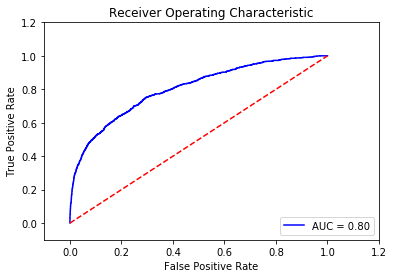

In [55]:
# Compute the FPR, TPR
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probs_test[:, 1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

# Plot an ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Part G3 - Look at the initial confusion matrix

In [56]:
def getMetrics(y_actual, y_pred, string = False):
    confusion = metrics.confusion_matrix(y_actual, y_pred)
    true_positive = confusion[1][1] # student enrolled and we predicted they would enroll
    false_positive = confusion[0][1] # student enrolled and we predicted they wouldn't enroll
    true_negative = confusion[0][0] # student didn't enroll and we predicted they wouldn't enroll
    false_negative = confusion[1][0] # student didn't enroll and we predicted they would enroll
    precision = metrics.precision_score(y_actual, y_pred)
    recall = metrics.recall_score(y_actual, y_pred)
    fscore = metrics.f1_score(y_actual, y_pred)
    output = {}
    if string:
        output = {'precision': str(precision), 
            'recall': str(recall), 
            'f_score': str(fscore), 
            'tp': str(true_positive), 
            'fp': str(false_positive), 
            'tn': str(true_negative), 
            'fn': str(false_negative)}
    else:
        output = {'precision': precision, 
            'recall': recall, 
            'f_score': fscore, 
            'tp': true_positive, 
            'fp': false_positive, 
            'tn': true_negative, 
            'fn': false_negative}
    return output

In [57]:
def generateReportString(metrics):
    output = 'Of the ' + str(metrics['tp'] + metrics['fn']) + ' students who enrolled at the UW, we correctly predicted '
    output = output + str(metrics['tp']) + ' of them.\n'
    output = output + 'Of the ' + str(metrics['tp'] + metrics['fp']) + ' students who we predicted would enroll at the UW, '
    output = output + str(metrics['tp']) + ' of them did\n'
    output = output + 'True positives: ' + str(metrics['tp']) + '; False positives: ' + str(metrics['fp']) + '\n'
    output = output + 'True negatives: ' + str(metrics['tn']) + '; False negatives: ' + str(metrics['fn']) + '\n'
    return output

In [58]:
y_array = np.array(y_train)
metricCalcs = getMetrics(y_array, predicts)

print generateReportString(metricCalcs)

Of the 4382 students who enrolled at the UW, we correctly predicted 4280 of them.
Of the 4280 students who we predicted would enroll at the UW, 4280 of them did
True positives: 4280; False positives: 0
True negatives: 28518; False negatives: 102



In [59]:
# Now do it for the TEST set
y_array = np.array(y_test)
metricCalcs = getMetrics(y_array, predicts_test)

print generateReportString(metricCalcs)
p = metricCalcs['precision']
r = metricCalcs['recall']

Of the 1095 students who enrolled at the UW, we correctly predicted 329 of them.
Of the 477 students who we predicted would enroll at the UW, 329 of them did
True positives: 329; False positives: 148
True negatives: 6982; False negatives: 766



### Part G4 - Find the best thresholds, F-Score optimize

In [60]:
def change_cutpoint(new_threshold, probs):
    array_to_return = np.zeros(len(probs))
    for index, value in enumerate(probs):
        if value >= new_threshold:
            #print index
            array_to_return[index] = 1
    return array_to_return

In [61]:
def generateOutputString(cutoff, metrics, students):
    output = 'Cutoff: ' + str(cutoff) + '; Predicted Enrollments: ' + str(students)
    output = output + ' -- Precision: ' + metrics['precision'] + '; Recall: ' + metrics['recall']
    output = output + '; F-score: ' + metrics['f_score'] + '; True Pos: ' + metrics['tp'] + '; False Pos: ' + metrics['fp']
    output = output + '; True Neg: ' + metrics['tn'] + '; False Neg: ' + metrics['fn']
    return output

In [62]:
y_array = np.array(y_test)
y_admitted = y_test.sum()
best = 0

flag = True
for number in range(100):
    cutoff = number / 100.0
    new_predictions = change_cutpoint(cutoff, probs_test[:, 1])
    metricCalcs = getMetrics(y_array, new_predictions, string = True)
    students = len(new_predictions[new_predictions >= cutoff])
    if students <= y_admitted and flag:
        best = cutoff
        flag = False
    print generateOutputString(cutoff, metricCalcs, students)

Cutoff: 0.0; Predicted Enrollments: 8225 -- Precision: 0.133130699088; Recall: 1.0; F-score: 0.234978540773; True Pos: 1095; False Pos: 7130; True Neg: 0; False Neg: 0
Cutoff: 0.01; Predicted Enrollments: 5887 -- Precision: 0.174622048582; Recall: 0.938812785388; F-score: 0.294471498138; True Pos: 1028; False Pos: 4859; True Neg: 2271; False Neg: 67
Cutoff: 0.02; Predicted Enrollments: 4611 -- Precision: 0.206029060941; Recall: 0.867579908676; F-score: 0.332982825096; True Pos: 950; False Pos: 3661; True Neg: 3469; False Neg: 145
Cutoff: 0.03; Predicted Enrollments: 3800 -- Precision: 0.233947368421; Recall: 0.811872146119; F-score: 0.363227783453; True Pos: 889; False Pos: 2911; True Neg: 4219; False Neg: 206
Cutoff: 0.04; Predicted Enrollments: 3226 -- Precision: 0.262244265344; Recall: 0.772602739726; F-score: 0.391576024069; True Pos: 846; False Pos: 2380; True Neg: 4750; False Neg: 249
Cutoff: 0.05; Predicted Enrollments: 2830 -- Precision: 0.28480565371; Recall: 0.736073059361; F

Cutoff: 0.47; Predicted Enrollments: 507 -- Precision: 0.67258382643; Recall: 0.311415525114; F-score: 0.425717852684; True Pos: 341; False Pos: 166; True Neg: 6964; False Neg: 754
Cutoff: 0.48; Predicted Enrollments: 497 -- Precision: 0.676056338028; Recall: 0.306849315068; F-score: 0.422110552764; True Pos: 336; False Pos: 161; True Neg: 6969; False Neg: 759
Cutoff: 0.49; Predicted Enrollments: 483 -- Precision: 0.685300207039; Recall: 0.302283105023; F-score: 0.419518377693; True Pos: 331; False Pos: 152; True Neg: 6978; False Neg: 764
Cutoff: 0.5; Predicted Enrollments: 477 -- Precision: 0.689727463312; Recall: 0.300456621005; F-score: 0.418575063613; True Pos: 329; False Pos: 148; True Neg: 6982; False Neg: 766
Cutoff: 0.51; Predicted Enrollments: 466 -- Precision: 0.697424892704; Recall: 0.296803652968; F-score: 0.416399743754; True Pos: 325; False Pos: 141; True Neg: 6989; False Neg: 770
Cutoff: 0.52; Predicted Enrollments: 456 -- Precision: 0.703947368421; Recall: 0.29315068493

Cutoff: 0.94; Predicted Enrollments: 110 -- Precision: 0.872727272727; Recall: 0.0876712328767; F-score: 0.159336099585; True Pos: 96; False Pos: 14; True Neg: 7116; False Neg: 999
Cutoff: 0.95; Predicted Enrollments: 97 -- Precision: 0.886597938144; Recall: 0.0785388127854; F-score: 0.144295302013; True Pos: 86; False Pos: 11; True Neg: 7119; False Neg: 1009
Cutoff: 0.96; Predicted Enrollments: 86 -- Precision: 0.895348837209; Recall: 0.0703196347032; F-score: 0.130397967824; True Pos: 77; False Pos: 9; True Neg: 7121; False Neg: 1018
Cutoff: 0.97; Predicted Enrollments: 73 -- Precision: 0.904109589041; Recall: 0.0602739726027; F-score: 0.11301369863; True Pos: 66; False Pos: 7; True Neg: 7123; False Neg: 1029
Cutoff: 0.98; Predicted Enrollments: 59 -- Precision: 0.932203389831; Recall: 0.0502283105023; F-score: 0.0953206239168; True Pos: 55; False Pos: 4; True Neg: 7126; False Neg: 1040
Cutoff: 0.99; Predicted Enrollments: 39 -- Precision: 0.974358974359; Recall: 0.034703196347; F-sc

In [63]:
print 'Total adjusted yield is: ' + str((clf.predict_proba(x_train.append(x_test))[:,1] > best).sum()) + ' students'
print 'Actual yield is: ' + str(isEnrolledOrMatriculated.sum()) + ' students'

Total adjusted yield is: 5573 students
Actual yield is: 5477 students


In [64]:
y_admitted, best

(1095L, 0.19)

#### Results Tracking

* Store in a Google sheet, https://docs.google.com/a/uw.edu/spreadsheets/d/1ne3dhmafyKZQNlTm7dlONYXvflGP-r3K-CeHfnOO6Qw/edit?usp=sharing 


### Part G5 - Save results

* Use pickle, https://docs.python.org/2/library/pickle.html 

In [65]:
if save_results:
    output_name = 'forOpt/boosting_model.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(clf, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved model'

Saved model


In [66]:
if save_results:
    pugoTuitionAndGrantData.to_csv('forOpt/pugoTuitionAndGrants.csv', index=False)
    print 'Saved pugo and grant amounts'

Saved pugo and grant amounts


In [67]:
if save_results:
    x.join(y, rsuffix = '_r').to_csv('forOpt/data_all.csv', index=False)
    print 'Saved transformed data set'

Saved transformed data set


In [68]:
if save_results:  
    scaler_file = 'forOpt/scaler.pkl'
    with open(scaler_file, 'wb') as output:
        pickle.dump(scaler, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved scaler'

Saved scaler


In [69]:
if save_results:
    output_name = 'forOpt/columns.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(x.columns, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved columns'

Saved columns


In [70]:
if save_results:
    output_name = 'forOpt/best_cutoff.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(best, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved cutoff'

Saved cutoff
